In [14]:
import os

os.chdir('c:\\Users\\inman\\Documents\\RDII\\CEE690_SoftwareEng_Spring26\\RDII')
os.getcwd()


'c:\\Users\\inman\\Documents\\RDII\\CEE690_SoftwareEng_Spring26\\RDII'

In [72]:
import pandas as pd
import matplotlib.pyplot as plt

og=pd.read_csv('data/processed/cleaned_bwi.csv')
og.head()

#df['DateTime'] = pd.to_datetime(df['DateTime'])

,DateTime,Flow_MGD,Meter,Source_File,QC_flag,Flow_MGD_BWI_Corrected
0,2023-01-01 12:00:00,1.496,CBO,DURHAM_CBO_20230101-20260101.csv,OK,0.766133
1,2023-01-01 12:15:00,1.505,CBO,DURHAM_CBO_20230101-20260101.csv,OK,0.775133
2,2023-01-01 12:30:00,1.516,CBO,DURHAM_CBO_20230101-20260101.csv,OK,0.786133
3,2023-01-01 12:45:00,1.547,CBO,DURHAM_CBO_20230101-20260101.csv,OK,0.817133
4,2023-01-01 13:00:00,1.516,CBO,DURHAM_CBO_20230101-20260101.csv,OK,0.786133


In [ ]:
# MAIN ALGORITHM OUTLINE
import holidays
import pandas as pd
import numpy as np  
from prophet import Prophet
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')




def detect_wet_dry_periods(df, k=3, max_iterations=50, threshold=0.05):
    """
    Iterative anomaly detection for I/I identification
    """
    
    # 1. INITIALIZE
    training_data = df[['DateTime', 'Flow_MGD_BWI_Corrected']].copy()

    training_data['DateTime'] = pd.to_datetime(training_data['DateTime'])
    
    training_data.rename(columns={
            'DateTime': 'ds',
            'Flow_MGD_BWI_Corrected': 'y'
        }, inplace=True)
    
    training_data = training_data.dropna()
    original_data = training_data.copy()

    ds_min = training_data['ds'].min()
    ds_max = training_data['ds'].max()

    # ensure min/max are valid datetimes
    if pd.isna(ds_min) or pd.isna(ds_max):
        raise ValueError("DateTime column contains NaT values.")

    us_holidays = holidays.US(years=range(ds_min.year, ds_max.year + 1))


    holiday_df = pd.DataFrame({
        'ds': pd.to_datetime(list(us_holidays.keys())),
        'holiday': list(us_holidays.values())
    })

    # Track iterations for visualization
    iteration_history = []
    previous_forecast = None

    iteration = 0
    
    while iteration < max_iterations:
        print(f"\nIteration {iteration + 1}:")

        # 2. TRAIN BWF RECONSTRUCTION MODEL (Prophet

        if iteration <= 1:
            fit_data = training_data.set_index('ds').resample('D').sum().reset_index().dropna()
            daily_seasonality = False
        elif iteration <= 4:
            fit_data = training_data.set_index('ds').resample('1h').mean().reset_index().dropna()
            daily_seasonality = True
        else:
            fit_data = training_data  # full resolution for final fit only
        
        model = Prophet(
            # Trend component (piecewise linear)
            growth='linear',
            changepoint_prior_scale=0.05,
            yearly_seasonality=6,
            weekly_seasonality=True,
            daily_seasonality=True,
            holidays=holiday_df
        )

        model.fit(fit_data, iter=200)
        
        #model.fit(training_data,iter=200)


        # 3. CALCULATE RESIDUALS (on training data only)
        # potentially revisit
        # Predict at fit_data resolution for residual calculation
        fit_forecast = model.predict(fit_data[['ds']])
        residuals = fit_data['y'].values - fit_forecast['yhat'].values

        # Predict on ORIGINAL data (not just training data)
        forecast = model.predict(original_data[['ds']])
        
        mu = residuals.mean()
        sigma = residuals.std()

        print(f"  Residual stats: μ={mu:.4f}, σ={sigma:.4f}")

        
        # 4. ANOMALY DETECTION (k-sigma rule)
        lower_bound = mu - k * sigma
        upper_bound = mu + k * sigma
        anomalies = (residuals < lower_bound) | (residuals > upper_bound)
        n_anomalies = anomalies.sum()
        print(f"  Anomalies detected: {n_anomalies} ({100*n_anomalies/len(training_data):.1f}%)")

        # Store iteration info
        iteration_history.append({
            'iteration': iteration,
            'forecast': forecast.copy(),
            'n_points': len(training_data),
            'n_anomalies': n_anomalies,
            'mu': mu,
            'sigma': sigma,
            'bounds': (lower_bound, upper_bound)
        })

        # 5. CHECK TERMINATION CONDITIONS
        should_terminate, reason = check_termination(
            residuals, forecast, previous_forecast, threshold
        )
        
        if should_terminate:
            print(f"\nTerminating: {reason}")
            break
        
        if n_anomalies == 0:
            print("\nTerminating: No more anomalies detected")
            break

        # 6. REMOVE ANOMALIES FOR NEXT ITERATION
        if iteration <= 2:
            # anomalies are indexed against daily fit_data
            # must map back to 15-min training_data by date
            anomalous_dates = fit_data['ds'][anomalies]
            training_data = training_data[~training_data['ds'].dt.date.isin(anomalous_dates.dt.date)]
        elif iteration <= 4:
            # anomalies are indexed against hourly fit_data
            # map back to 15-min training_data by hour
            anomalous_hours = fit_data['ds'][anomalies]
            training_data = training_data[~training_data['ds'].dt.floor('1h').isin(anomalous_hours)]
        else:
            # anomalies are indexed directly against 15-min training_data
            training_data = training_data.loc[~anomalies]
        
        previous_forecast = forecast
        iteration += 1



    
    print(f"\nCompleted after {iteration + 1} iterations")
    
    # 7. FINAL ANOMALY CLASSIFICATION on all original data
    final_forecast = iteration_history[-1]['forecast']
    final_residuals = original_data['y'].values - final_forecast['yhat'].values
    final_mu = iteration_history[-1]['mu']
    final_sigma = iteration_history[-1]['sigma']
    final_lower = final_mu - k * final_sigma
    final_upper = final_mu + k * final_sigma
    
    anomaly_labels = (final_residuals < final_lower) | (final_residuals > final_upper)
    
    # 8. ISOLATED POINT REMOVAL
    anomaly_labels_cleaned = remove_isolated_points(anomaly_labels.astype(np.bool_), window_size=12)

    
    print(f"\nFinal classification:")
    print(f"  Anomalous points: {anomaly_labels_cleaned.sum()} ({100*anomaly_labels_cleaned.sum()/len(anomaly_labels_cleaned):.1f}%)")
    print(f"  Normal points: {(~anomaly_labels_cleaned).sum()} ({100*(~anomaly_labels_cleaned).sum()/len(anomaly_labels_cleaned):.1f}%)")
    
    # 9. CALCULATE RESIDUAL FLOW (anomalous deviation from forecast)
    residual_flow = original_data['y'].values - final_forecast['yhat'].values
    residual_flow[~anomaly_labels_cleaned] = 0  # Zero out non-anomalous points
    
    return {
        'anomaly_labels': anomaly_labels_cleaned,
        'residual_flow': residual_flow,
        'forecast': final_forecast,
        'original_data': original_data,
        'iteration_history': iteration_history,
        'final_bounds': (final_lower, final_upper)
    }



def check_termination(residuals, current_forecast, previous_forecast, threshold):
    """
    Check if any termination condition is met

    """
    
    # Condition 1: Normality test (Anderson-Darling)
    result = stats.anderson(residuals, dist='norm')
    # If statistic < critical value, data is normal
    if result.statistic < result.critical_values[2]:  # 5% significance
        return True, "Residuals pass normality test"
    
    # Condition 2: Maximum residual threshold
    max_abs_residual = np.abs(residuals).max()
    if max_abs_residual < threshold:
        return True, f"Max residual ({max_abs_residual:.4f}) below threshold ({threshold})"
    
    # Condition 3: High correlation between successive forecasts
    if previous_forecast is not None:
        correlation, _ = pearsonr(
            current_forecast['yhat'].values,
            previous_forecast['yhat'].values
        )
        if correlation > 0.999:
            return True, f"High correlation ({correlation:.6f}) between successive forecasts"
    
    return False, None


def remove_isolated_points(labels, window_size=12):
    n = len(labels)
    cleaned = np.empty(n, dtype=bool)
    half = window_size // 2
    for i in range(n):
        start = max(0, i - half)
        end = min(n, i + half + 1)
        count_true = 0
        for j in range(start, end):
            if labels[j]:
                count_true += 1
        if count_true > (end - start) / 2:
            cleaned[i] = True
        else:
            cleaned[i] = False
    return cleaned




In [85]:
CBO=og[og['Meter']=="CBO"]
CBO.head(2)
CBO.dtypes

DateTime                   object
Flow_MGD                  float64
Meter                      object
Source_File                object
QC_flag                    object
Flow_MGD_BWI_Corrected    float64
dtype: object

In [127]:
# Run the detection
results = detect_wet_dry_periods(
    CBO,
    k=2.5,
    max_iterations=5,
    threshold=0.5
)




Iteration 1:


21:56:12 - cmdstanpy - INFO - Chain [1] start processing
21:56:12 - cmdstanpy - INFO - Chain [1] done processing


  Residual stats: μ=0.0070, σ=36.3776
  Anomalies detected: 30 (0.0%)

Iteration 2:


21:56:33 - cmdstanpy - INFO - Chain [1] start processing
21:56:33 - cmdstanpy - INFO - Chain [1] done processing


  Residual stats: μ=-0.0011, σ=26.4490
  Anomalies detected: 52 (0.1%)

Iteration 3:


21:56:57 - cmdstanpy - INFO - Chain [1] start processing
21:56:59 - cmdstanpy - INFO - Chain [1] done processing


  Residual stats: μ=-0.0000, σ=0.2476
  Anomalies detected: 701 (0.7%)

Iteration 4:


21:57:24 - cmdstanpy - INFO - Chain [1] start processing
21:57:26 - cmdstanpy - INFO - Chain [1] done processing


  Residual stats: μ=-0.0000, σ=0.1278
  Anomalies detected: 568 (0.7%)

Iteration 5:


21:57:49 - cmdstanpy - INFO - Chain [1] start processing
21:57:51 - cmdstanpy - INFO - Chain [1] done processing


  Residual stats: μ=0.0001, σ=0.1043
  Anomalies detected: 420 (0.6%)

Terminating: Max residual (0.3589) below threshold (0.5)

Completed after 5 iterations

Final classification:
  Anomalous points: 16917 (17.0%)
  Normal points: 82514 (83.0%)


In [128]:
def plot_iterations(results, k, show_every_n=5):
    """
    Plot the BWF reconstruction for each iteration
    """
    
    fig, axes = plt.subplots(1, 1, figsize=(15, 10))
    
    original = results['original_data']
    history = results['iteration_history']
    
    # Bottom plot: Final result with wet/dry classification
    
    anomaly_labels = results['anomaly_labels']
    final_forecast = results['forecast']
    bounds = results['final_bounds']
    
    # Plot normal points
    normal_mask = ~anomaly_labels
    axes.plot(original['ds'][normal_mask], original['y'][normal_mask], 'o',
             color='blue', alpha=0.5, markersize=3, label='Normal')
    
    # Plot anomalous points
    anomaly_mask = anomaly_labels
    axes.plot(original['ds'][anomaly_mask], original['y'][anomaly_mask], 'o',
             color='red', alpha=0.5, markersize=3, label='Anomaly')
    
    # Plot final forecast
    axes.plot(final_forecast['ds'], final_forecast['yhat'],
             linewidth=2, color='darkblue', label='Forecast', zorder=5)
    
    # Plot confidence bounds
    axes.fill_between(final_forecast['ds'],
                     final_forecast['yhat'] + bounds[0],
                     final_forecast['yhat'] + bounds[1],
                     alpha=0.2, color='blue', label=f'{k}σ Bounds')
    
    axes.set_xlabel('Date', fontsize=12)
    axes.set_ylabel('Flow (MGD)', fontsize=12)
    axes.set_title('Final Anomaly Classification', fontsize=14, fontweight='bold')
    axes.legend(loc='upper right', fontsize=10)
    axes.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('anomaly_detection_iterations.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Additional plot: Iteration statistics
    fig2, axes2 = plt.subplots(2, 2, figsize=(14, 10))
    
    iterations = [h['iteration'] + 1 for h in history]
    n_points = [h['n_points'] for h in history]
    n_anomalies = [h['n_anomalies'] for h in history]
    sigmas = [h['sigma'] for h in history]
    mus = [h['mu'] for h in history]
    
    # Training points
    axes2[0, 0].plot(iterations, n_points, 'o-', linewidth=2, markersize=8)
    axes2[0, 0].set_xlabel('Iteration')
    axes2[0, 0].set_ylabel('Training Points Remaining')
    axes2[0, 0].set_title('Training Data Reduction')
    axes2[0, 0].grid(True, alpha=0.3)
    
    # Anomalies per iteration
    axes2[0, 1].bar(iterations, n_anomalies, color='coral', alpha=0.7)
    axes2[0, 1].set_xlabel('Iteration')
    axes2[0, 1].set_ylabel('Anomalies Detected')
    axes2[0, 1].set_title('Anomalies Removed Per Iteration')
    axes2[0, 1].grid(True, alpha=0.3, axis='y')
    
    # Standard deviation
    axes2[1, 0].plot(iterations, sigmas, 's-', linewidth=2, markersize=8, color='green')
    axes2[1, 0].set_xlabel('Iteration')
    axes2[1, 0].set_ylabel('Standard Deviation (σ)')
    axes2[1, 0].set_title('Residual Standard Deviation')
    axes2[1, 0].grid(True, alpha=0.3)
    
    # Mean
    axes2[1, 1].plot(iterations, mus, 'd-', linewidth=2, markersize=8, color='purple')
    axes2[1, 1].axhline(y=0, color='red', linestyle='--', alpha=0.5)
    axes2[1, 1].set_xlabel('Iteration')
    axes2[1, 1].set_ylabel('Mean Residual (μ)')
    axes2[1, 1].set_title('Residual Mean Convergence')
    axes2[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('anomaly_detection_statistics.png', dpi=300, bbox_inches='tight')
    plt.show()

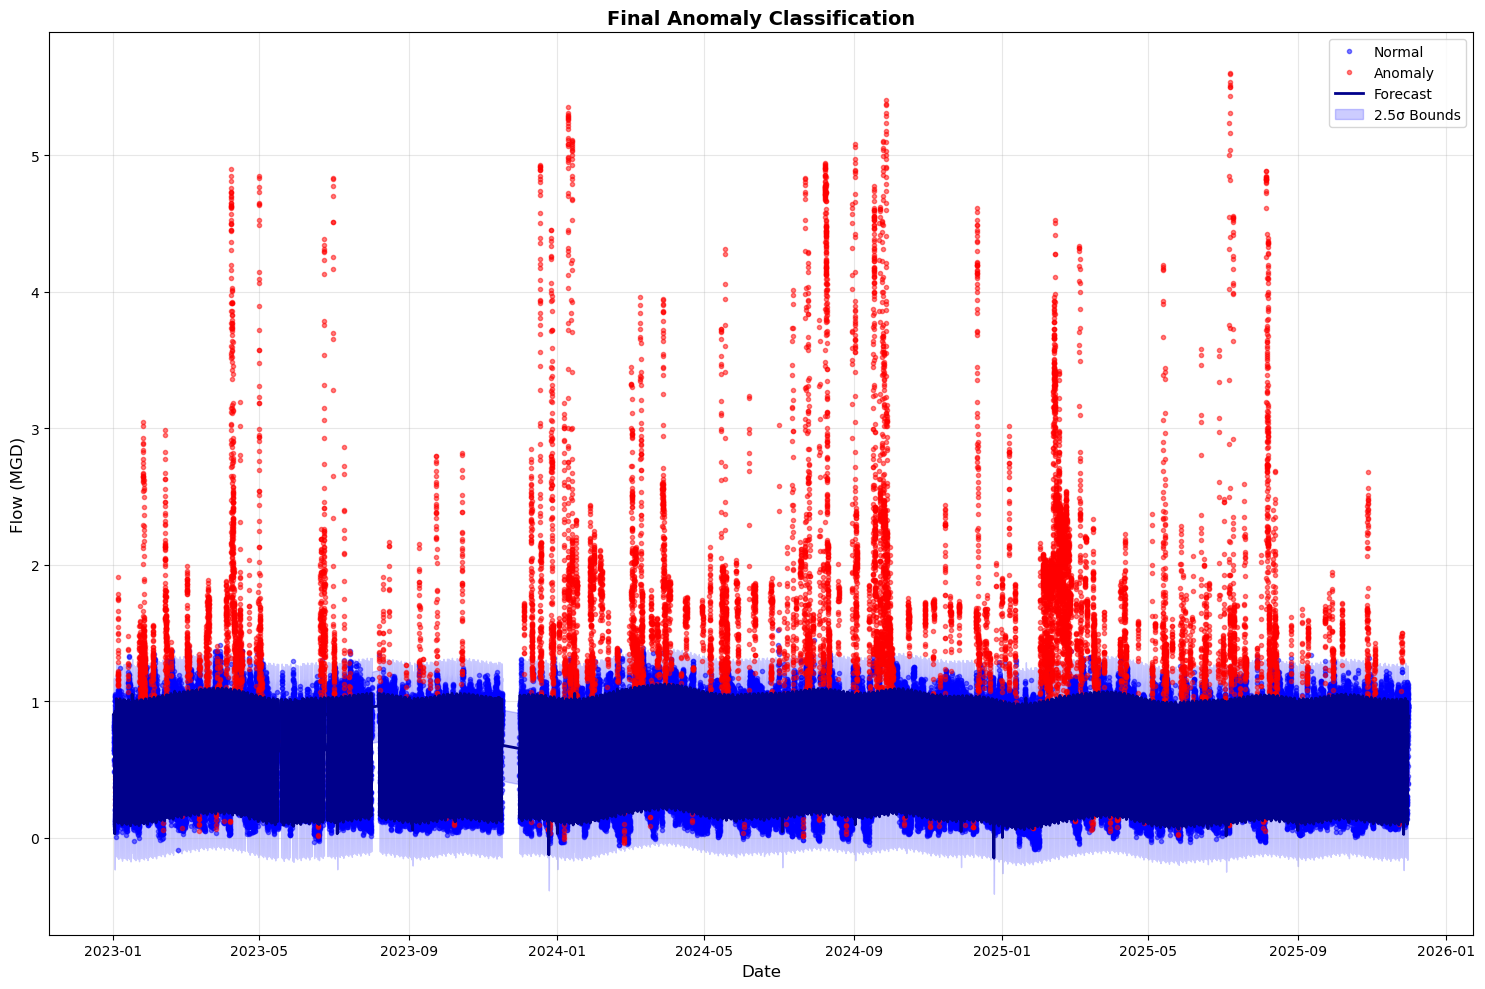

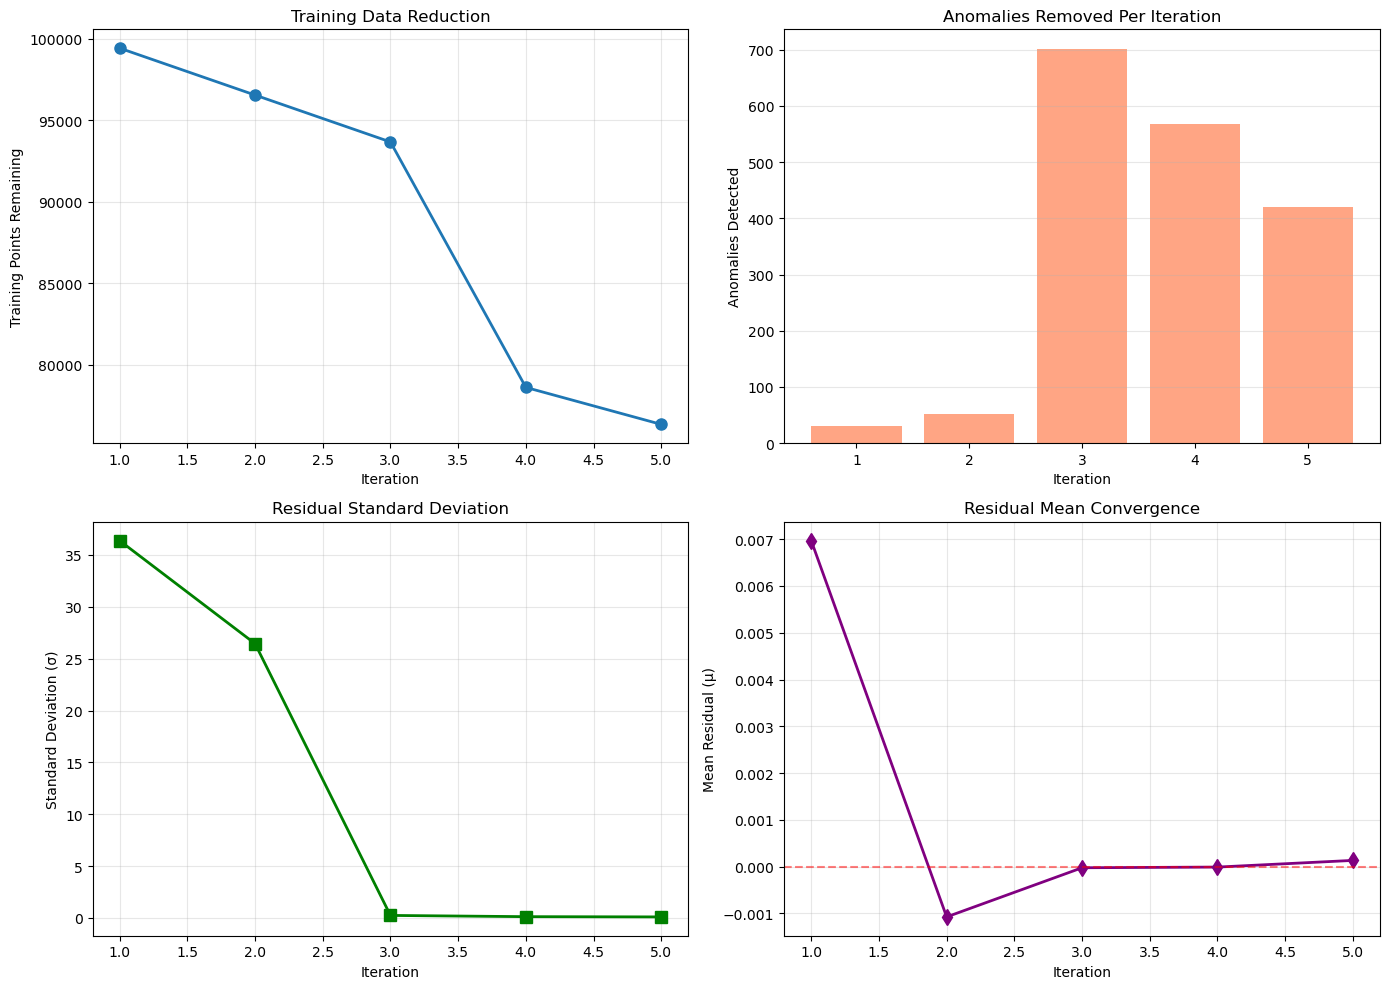

In [129]:
# Visualize
plot_iterations(results, 2.5 ,show_every_n=3)

In [ ]:
# hybrid prohpeht++ STL decomposition

In [119]:
import holidays
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from statsmodels.tsa.seasonal import STL
import warnings
warnings.filterwarnings('ignore')


def estimate_baseflow(df, k=2.5, max_iterations=10, min_anomaly_fraction=0.001):
    """
    Estimate dry weather baseflow using hybrid STL + Prophet approach.

    Phase 1: Iterative STL decomposition to identify and remove rain-affected
             periods, converging on a clean dry weather training dataset.
    Phase 2: Single Prophet fit on clean data to produce a smooth baseflow
             estimate across the entire record, including storm periods.

    Parameters
    ----------
    df : DataFrame with columns 'DateTime' and 'Flow_MGD_BWI_Corrected'
    k : float
        Sigma multiplier for anomaly detection bounds (default 2.5)
    max_iterations : int
        Maximum STL cleaning iterations (default 10)
    min_anomaly_fraction : float
        Stop iterating when fewer than this fraction of points are flagged (default 0.001 = 0.1%)

    Returns
    -------
    dict with keys:
        'baseflow'          : full Prophet forecast DataFrame (yhat = baseflow estimate)
        'dry_weather_data'  : clean training dataset used for final Prophet fit
        'original_data'     : full original dataset
        'anomaly_labels'    : boolean array, True = rain-affected point
        'iteration_history' : list of dicts with per-iteration stats
    """

    # -------------------------------------------------------------------------
    # 1. INITIALIZE
    # -------------------------------------------------------------------------
    training_data = df[['DateTime', 'Flow_MGD_BWI_Corrected']].copy()
    training_data['DateTime'] = pd.to_datetime(training_data['DateTime'])
    training_data.rename(columns={
        'DateTime': 'ds',
        'Flow_MGD_BWI_Corrected': 'y'
    }, inplace=True)
    training_data = training_data.dropna().reset_index(drop=True)
    original_data = training_data.copy()

    ds_min = training_data['ds'].min()
    ds_max = training_data['ds'].max()

    if pd.isna(ds_min) or pd.isna(ds_max):
        raise ValueError("DateTime column contains NaT values.")

    # Build US holiday dataframe for Prophet
    us_holidays = holidays.US(years=range(ds_min.year, ds_max.year + 1))
    holiday_df = pd.DataFrame({
        'ds': pd.to_datetime(list(us_holidays.keys())),
        'holiday': list(us_holidays.values())
    })

    iteration_history = []
    iteration = 0

    # -------------------------------------------------------------------------
    # 2. PHASE 1: ITERATIVE STL CLEANING
    # -------------------------------------------------------------------------
    print("=" * 50)
    print("PHASE 1: STL Iterative Cleaning")
    print("=" * 50)

    while iteration < max_iterations:
        print(f"\nSTL Iteration {iteration + 1}:")
        print(f"  Training points: {len(training_data)} ({len(training_data) // 96} days)")

        # STL requires a regularly-spaced series with no gaps
        # Reindex to fill any gaps introduced by previous removals
        ts = training_data.set_index('ds')['y']

        # STL decomposition
        # period=96: one full day at 15-min resolution
        # seasonal=13: seasonal smoother span (must be odd, >= 7)
        stl = STL(ts, period=96, seasonal=13,)
        result = stl.fit()
        residuals = result.resid.values

        mu = residuals.mean()
        sigma = residuals.std()
        lower_bound = mu - k * sigma
        upper_bound = mu + k * sigma

        anomalies = (residuals < lower_bound) | (residuals > upper_bound)
        n_anomalies = anomalies.sum()
        anomaly_fraction = n_anomalies / len(training_data)

        print(f"  Residual stats: μ={mu:.4f}, σ={sigma:.4f}")
        print(f"  Anomalies detected: {n_anomalies} ({100 * anomaly_fraction:.2f}%)")

        iteration_history.append({
            'iteration': iteration,
            'phase': 'STL',
            'n_points': len(training_data),
            'n_anomalies': int(n_anomalies),
            'mu': mu,
            'sigma': sigma,
            'bounds': (lower_bound, upper_bound)
        })

        # Termination: converged when very few anomalies remain
        if n_anomalies == 0:
            print("  Terminating: No anomalies detected")
            break

        if anomaly_fraction < min_anomaly_fraction:
            print(f"  Terminating: Anomaly fraction ({anomaly_fraction:.4f}) below threshold")
            break

        # Remove anomalous points from training data
        training_data = training_data[~anomalies].reset_index(drop=True)
        iteration += 1

    print(f"\nPhase 1 complete after {iteration + 1} iterations")
    print(f"Clean training set: {len(training_data)} points ({len(training_data) // 96} days)")
    print(f"Removed: {len(original_data) - len(training_data)} points "
          f"({100 * (len(original_data) - len(training_data)) / len(original_data):.1f}%)")

    # -------------------------------------------------------------------------
    # 3. PHASE 2: SINGLE PROPHET FIT ON CLEAN DATA
    # -------------------------------------------------------------------------
    print("\n" + "=" * 50)
    print("PHASE 2: Prophet Baseflow Estimation")
    print("=" * 50)

    final_model = Prophet(
        growth='linear',
        changepoint_prior_scale=0.05,
        yearly_seasonality=6,   # reduced Fourier terms for speed
        weekly_seasonality=3,
        daily_seasonality=6,
        holidays=holiday_df
    )

    print("\nFitting Prophet on clean dry weather data...")
    final_model.fit(training_data, iter=500)

    # Predict across entire original timeline
    # yhat during storm periods = counterfactual baseflow estimate
    print("Predicting baseflow across full record...")
    baseflow = final_model.predict(original_data[['ds']])

    # -------------------------------------------------------------------------
    # 4. FINAL ANOMALY LABELS
    # -------------------------------------------------------------------------
    # Flag any point not in the clean training set as rain-affected
    clean_ds = set(training_data['ds'])
    anomaly_labels = ~original_data['ds'].isin(clean_ds).values

    print(f"\nFinal classification:")
    print(f"  Dry weather points: {(~anomaly_labels).sum()} "
          f"({100 * (~anomaly_labels).sum() / len(anomaly_labels):.1f}%)")
    print(f"  Rain-affected points: {anomaly_labels.sum()} "
          f"({100 * anomaly_labels.sum() / len(anomaly_labels):.1f}%)")

    return {
        'baseflow': baseflow,               # Prophet forecast — yhat is your answer
        'dry_weather_data': training_data,  # clean training set
        'original_data': original_data,     # full original record
        'anomaly_labels': anomaly_labels,   # True = rain-affected
        'iteration_history': iteration_history
    }


def plot_baseflow(results, k):
    """
    Plot baseflow estimation results.

    Top panel: measured flow with rain-affected periods highlighted,
               overlaid with Prophet baseflow estimate.
    Bottom panel: iteration statistics from STL cleaning phase.
    """

    original = results['original_data']
    baseflow = results['baseflow']
    anomaly_labels = results['anomaly_labels']
    history = results['iteration_history']

    fig, axes = plt.subplots(2, 1, figsize=(15, 10))

    # -------------------------------------------------------------------------
    # Top plot: Measured flow + baseflow estimate
    # -------------------------------------------------------------------------
    ax1 = axes[0]

    dry_mask = ~anomaly_labels
    wet_mask = anomaly_labels

    ax1.plot(original['ds'][dry_mask], original['y'][dry_mask], 'o',
             color='steelblue', alpha=0.4, markersize=2, label='Dry Weather Flow')
    ax1.plot(original['ds'][wet_mask], original['y'][wet_mask], 'o',
             color='coral', alpha=0.4, markersize=2, label='Rain-Affected Flow')
    ax1.plot(baseflow['ds'], baseflow['yhat'],
             linewidth=2, color='darkblue', label='Estimated Baseflow', zorder=5)
    ax1.fill_between(baseflow['ds'],
                     baseflow['yhat_lower'],
                     baseflow['yhat_upper'],
                     alpha=0.15, color='steelblue', label='Prophet 80% Interval')

    ax1.set_xlabel('Date', fontsize=12)
    ax1.set_ylabel('Flow (MGD)', fontsize=12)
    ax1.set_title('Baseflow Estimation — Hybrid STL + Prophet', fontsize=14, fontweight='bold')
    ax1.legend(loc='upper right', fontsize=9)
    ax1.grid(True, alpha=0.3)

    # -------------------------------------------------------------------------
    # Bottom plot: STL iteration statistics
    # -------------------------------------------------------------------------
    ax2 = axes[1]

    iterations = [h['iteration'] + 1 for h in history]
    n_points = [h['n_points'] for h in history]
    n_anomalies = [h['n_anomalies'] for h in history]

    ax2_twin = ax2.twinx()
    ax2.bar(iterations, n_anomalies, color='coral', alpha=0.6, label='Anomalies Removed')
    ax2_twin.plot(iterations, n_points, 'o-', color='steelblue',
                  linewidth=2, markersize=6, label='Training Points Remaining')

    ax2.set_xlabel('STL Iteration', fontsize=12)
    ax2.set_ylabel('Anomalies Removed', fontsize=12, color='coral')
    ax2_twin.set_ylabel('Training Points Remaining', fontsize=12, color='steelblue')
    ax2.set_title('STL Cleaning Convergence', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='y')

    # Combined legend
    lines1, labels1 = ax2.get_legend_handles_labels()
    lines2, labels2 = ax2_twin.get_legend_handles_labels()
    ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right', fontsize=9)

    plt.tight_layout()
    plt.savefig('baseflow_estimation.png', dpi=300, bbox_inches='tight')
    plt.show()

In [120]:
# Run the detection
results = estimate_baseflow(
    CBO,
    k=2.5,
    max_iterations=5,
    min_anomaly_fraction=0.001
)


PHASE 1: STL Iterative Cleaning

STL Iteration 1:
  Training points: 99431 (1035 days)
  Residual stats: μ=-0.0000, σ=0.2106
  Anomalies detected: 2647 (2.66%)

STL Iteration 2:
  Training points: 96784 (1008 days)
  Residual stats: μ=-0.0000, σ=0.1686
  Anomalies detected: 3262 (3.37%)

STL Iteration 3:
  Training points: 93522 (974 days)
  Residual stats: μ=-0.0000, σ=0.1569
  Anomalies detected: 3082 (3.30%)

STL Iteration 4:
  Training points: 90440 (942 days)
  Residual stats: μ=-0.0000, σ=0.1525
  Anomalies detected: 2783 (3.08%)

STL Iteration 5:
  Training points: 87657 (913 days)
  Residual stats: μ=-0.0000, σ=0.1492
  Anomalies detected: 2549 (2.91%)

Phase 1 complete after 6 iterations
Clean training set: 85108 points (886 days)
Removed: 14323 points (14.4%)

PHASE 2: Prophet Baseflow Estimation

Fitting Prophet on clean dry weather data...


21:52:28 - cmdstanpy - INFO - Chain [1] start processing
21:52:47 - cmdstanpy - INFO - Chain [1] done processing


Predicting baseflow across full record...

Final classification:
  Dry weather points: 85108 (85.6%)
  Rain-affected points: 14323 (14.4%)


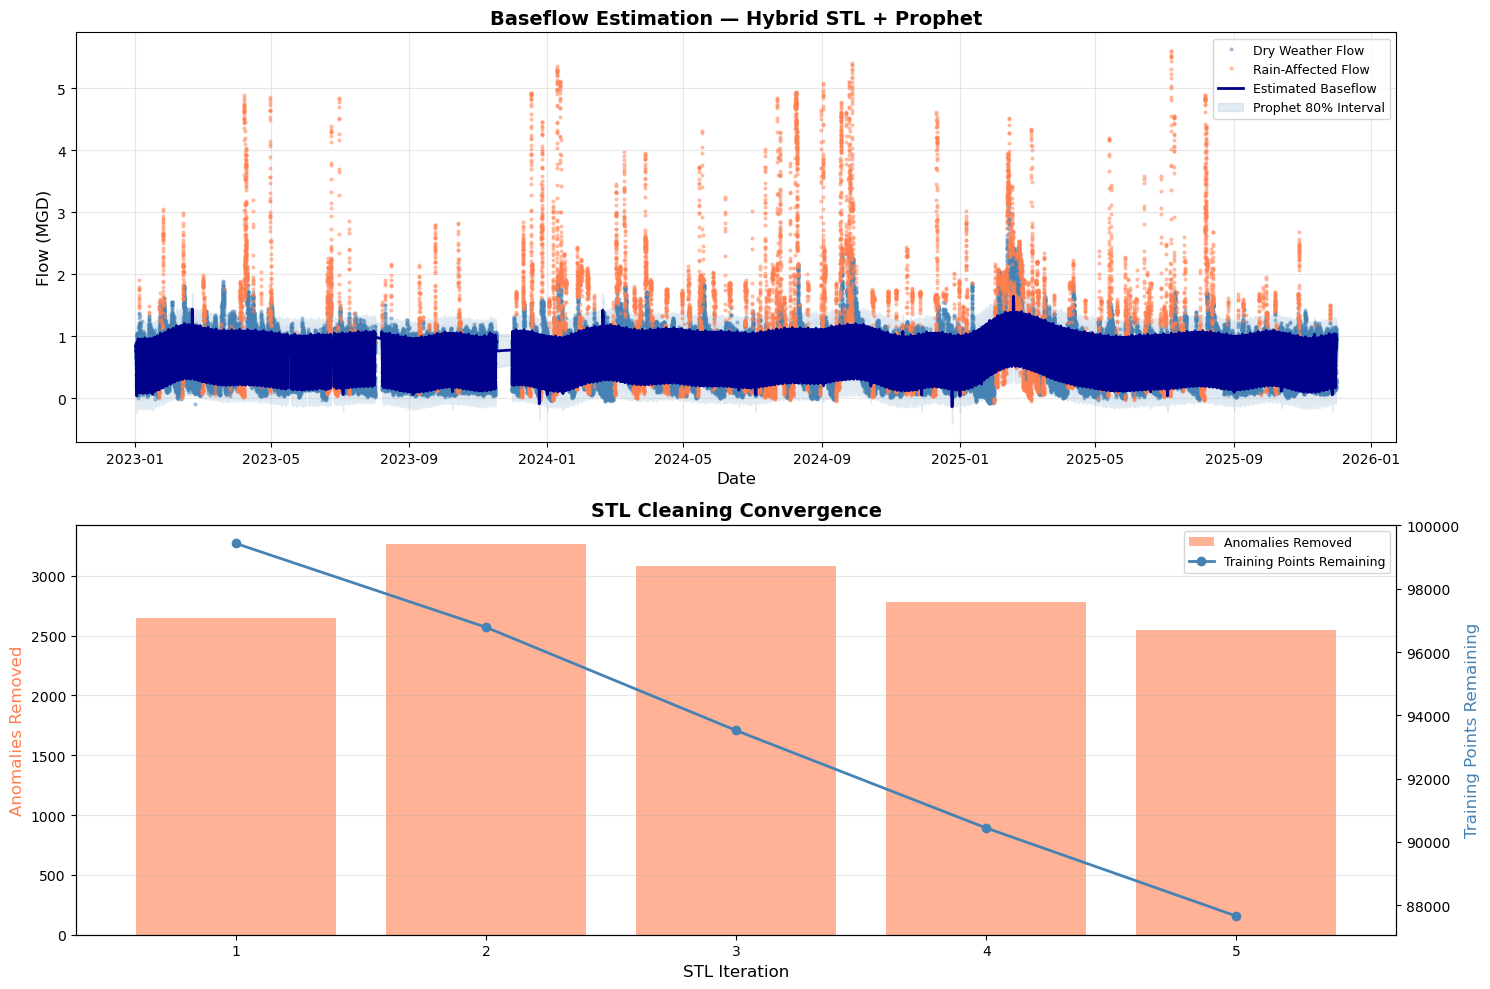

In [121]:
plot_baseflow(results, k=2.5)